# 02 — Backtest Analysis (Equity & Drawdown)

Este notebook:
1) roda um backtest via **API**,
2) busca os **resultados** (métricas, trades, curva diária),
3) plota **equity curve** e **drawdown**,

> **Pré-requisitos**
> - API rodando em `http://localhost:8000`
> - Pacotes: `pandas`, `matplotlib`, `requests`, `yfinance` (opcional), `mplfinance` (opcional p/ candles)
> - Instale se faltar:



In [ ]:
BASE = "http://localhost:8000"

TICKER = "PETR4.SA"
START  = "2022-01-01"
END    = "2025-09-01"

BT_PARAMS = {
    "ticker": TICKER,
    "start_date": START,
    "end_date": END,
    "initial_cash": 100000,
    "commission": 0.0005,
    "sma_fast": 20,
    "sma_slow": 50,
    "atr_window": 14,
    "atr_k": 2.0,
    "risk_perc": 0.01,
    "strategy_type": "sma_cross",
    "strategy_params": {}
}


In [50]:
import requests

r = requests.get(f"{BASE}/health", timeout=10)
print("GET /health:", r.status_code, r.text)


GET /health: 200 {"status":"ok","db":true}


In [51]:
import requests, pandas as pd

bt = requests.post(f"{BASE}/backtests/run", json=BT_PARAMS, timeout=300).json()
bt


{'backtest_id': 10,
 'metrics': {'final_value': 85423.09350127795,
  'return_pct': -0.14576906498722053,
  'max_drawdown_pct': 14.612410477432627,
  'sharpe_a': -1.167243797873386,
  'total_trades': 13,
  'won': 1,
  'lost': 12}}

In [52]:
bt_id = bt["backtest_id"]
res = requests.get(f"{BASE}/backtests/{bt_id}/results", timeout=120).json()
res.keys(), res["metrics"]


(dict_keys(['backtest_id', 'ticker', 'strategy_type', 'metrics', 'trades', 'daily_positions']),
 {'final_value': 85423.09350127795,
  'return_pct': -0.14576906498722053,
  'max_drawdown_pct': 14.612410477432627,
  'sharpe_a': -1.167243797873386,
  'total_trades': 13.0,
  'won': 1.0,
  'lost': 12.0})

In [53]:
import pandas as pd
import numpy as np

trades = pd.DataFrame(res.get("trades", []))
daily  = pd.DataFrame(res.get("daily_positions", []))

# Normalizações
for df in [trades, daily]:
    if not df.empty and "date" in df:
        df["date"] = pd.to_datetime(df["date"])

# Métricas em Series p/ print bonitinho
metrics = pd.Series(res.get("metrics", {}))
display(metrics)
display(trades.head())
display(daily.head())


final_value         85423.093501
return_pct             -0.145769
max_drawdown_pct       14.612410
sharpe_a               -1.167244
total_trades           13.000000
won                     1.000000
lost                   12.000000
dtype: float64

,date,side,price,size,pnl
0,2022-04-25,BUY,30.110001,1,-487.513856
1,2022-06-10,BUY,29.650000,1,-2549.271588
2,2022-09-23,BUY,29.940001,1,-1122.110685
3,2022-11-14,BUY,27.700001,1,-3337.876718
4,2023-03-17,BUY,23.510000,1,-1766.641699


,date,position,cash,equity
0,2022-01-03,0,100000.0,100000.0
1,2022-01-04,0,100000.0,100000.0
2,2022-01-05,0,100000.0,100000.0
3,2022-01-06,0,100000.0,100000.0
4,2022-01-07,0,100000.0,100000.0


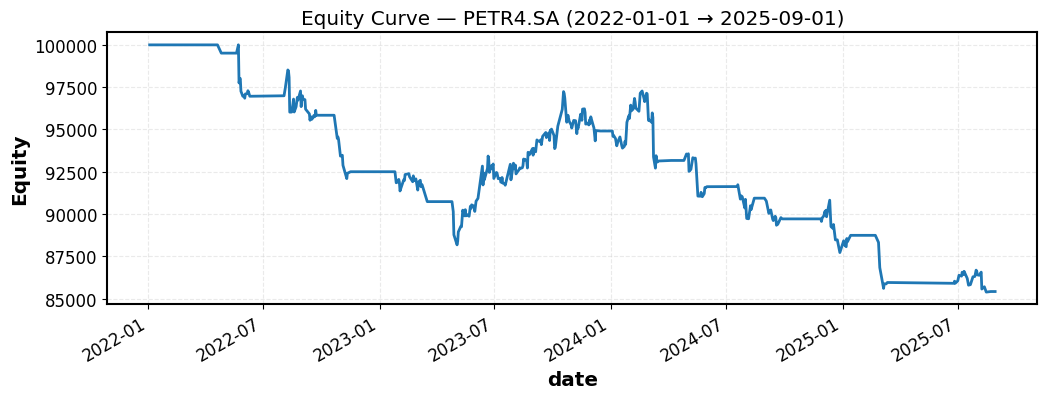

In [54]:
import matplotlib.pyplot as plt

if daily.empty:
    print("Sem dados diários para plotar.")
else:
    d = daily.sort_values("date").set_index("date")
    ax = d["equity"].plot(figsize=(12,4))
    ax.set_title(f"Equity Curve — {TICKER} ({START} → {END})")
    ax.set_ylabel("Equity")
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.show()


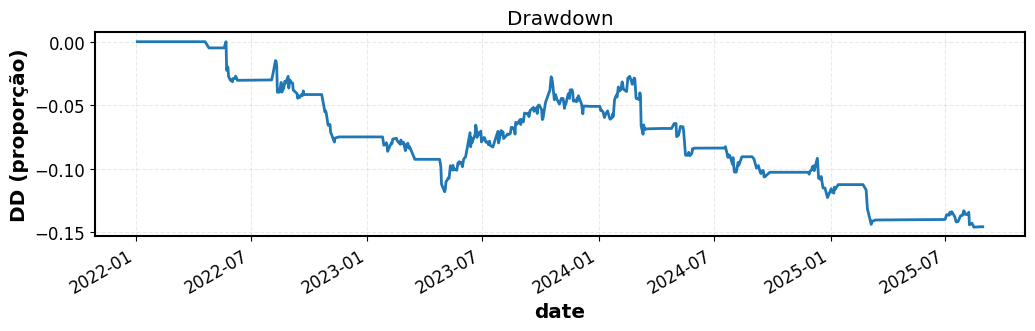

In [55]:
import numpy as np

if daily.empty:
    print("Sem dados diários para drawdown.")
else:
    d = daily.sort_values("date").set_index("date")
    roll_max = d["equity"].cummax()
    dd = d["equity"] / roll_max - 1.0
    ax = dd.plot(figsize=(12,3))
    ax.set_title("Drawdown")
    ax.set_ylabel("DD (proporção)")
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.show()
